# Finetuning Resnet Model

Reference: https://keras.io/guides/transfer_learning/

## Load and Split Dataset

In [1]:
!pip install tensorflow_addons

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 50
BASE_LEARNING_RATE = 0.001
BATCH_SIZE = 64

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))
    
#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 192
Number of validation samples: 55
Number of test samples: 28


## Model Definition

In [4]:
base_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = None)
base_model.trainable = False

# Image augmentation layers
rotation_layer = tf.keras.layers.RandomRotation(0.5, seed = RANDOM_STATE)
flipping_layer = tf.keras.layers.RandomFlip(seed = RANDOM_STATE)

# Prediction layers
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

inputs = tf.keras.Input(shape = (256, 256, 3))
x = flipping_layer(inputs)
x = rotation_layer(x)
x = tf.keras.applications.resnet50.preprocess_input(x) # convert RGB to BGR, then zero-center color channel wrt ImageNet without scaling
x = base_model(x, training = False)
x = pooling_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

adam = tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['Precision', 'Recall', 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

### Initial Training of Classification Head

Batch Size used - 128

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = EARLY_STOPPING_PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

history = model.fit(train_ds, validation_data = validation_ds, 
                    epochs = MAX_EPOCHS, callbacks = [early_stopping, reduce_lr], batch_size = BATCH_SIZE)

Epoch 1/1000


2021-11-17 03:19:54.319367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 03:19:59.893064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


96/96 [==============================] - 82s 729ms/step - loss: 1.1696 - precision: 0.7129 - recall: 0.4835 - accuracy: 0.6120 - val_loss: 0.7793 - val_precision: 0.7834 - val_recall: 0.6485 - val_accuracy: 0.7224
Epoch 2/1000
96/96 [==============================] - 64s 666ms/step - loss: 0.7496 - precision: 0.8097 - recall: 0.6493 - accuracy: 0.7365 - val_loss: 0.6381 - val_precision: 0.8307 - val_recall: 0.7173 - val_accuracy: 0.7758
Epoch 3/1000
96/96 [==============================] - 64s 667ms/step - loss: 0.6582 - precision: 0.8297 - recall: 0.6972 - accuracy: 0.7668 - val_loss: 0.5967 - val_precision: 0.8431 - val_recall: 0.7347 - val_accuracy: 0.7955
Epoch 4/1000
96/96 [==============================] - 64s 667ms/step - loss: 0.6012 - precision: 0.8457 - recall: 0.7311 - accuracy: 0.7910 - val_loss: 0.5685 - val_precision: 0.8494 - val_recall: 0.7519 - val_accuracy: 0.8024
Epoch 5/1000
96/96 [==============================] - 64s 667ms/step - loss: 0.5647 - precision: 0.8562 -

In [13]:
from sklearn.metrics import classification_report

def plotResults(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    precision = hist.history['precision']
    val_precision = hist.history['val_precision']
    recall = hist.history['recall']
    val_recall = hist.history['val_recall']

    # Plot the graph manually
    epochs = range(len(loss))

    plt.figure(figsize=(20, 20))
    plt.subplot(4, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(epochs, precision, 'r', label='Training Precision')
    plt.plot(epochs, val_precision, 'b', label='Validation Precision')
    plt.title('Training and validation Precision')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(epochs, recall, 'r', label = "Training Recall")
    plt.plot(epochs, val_recall, 'b', label='Validation Recall')
    plt.title('Training and validation Recall')
    plt.legend()

    plt.show()
    
def printClassificationReport(model, val_ds):
    # Convert validation dataset into X_val, y_val
    val_numpy = tfds.as_numpy(val_ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in val_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)

    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X_val = np.concatenate(X_batches, axis = 0)
    y_val = np.concatenate(y_batches, axis = 0)

    # Print classification report
    y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index
    print(y_val.shape, y_pred.shape)

    print(classification_report(y_val, y_pred))

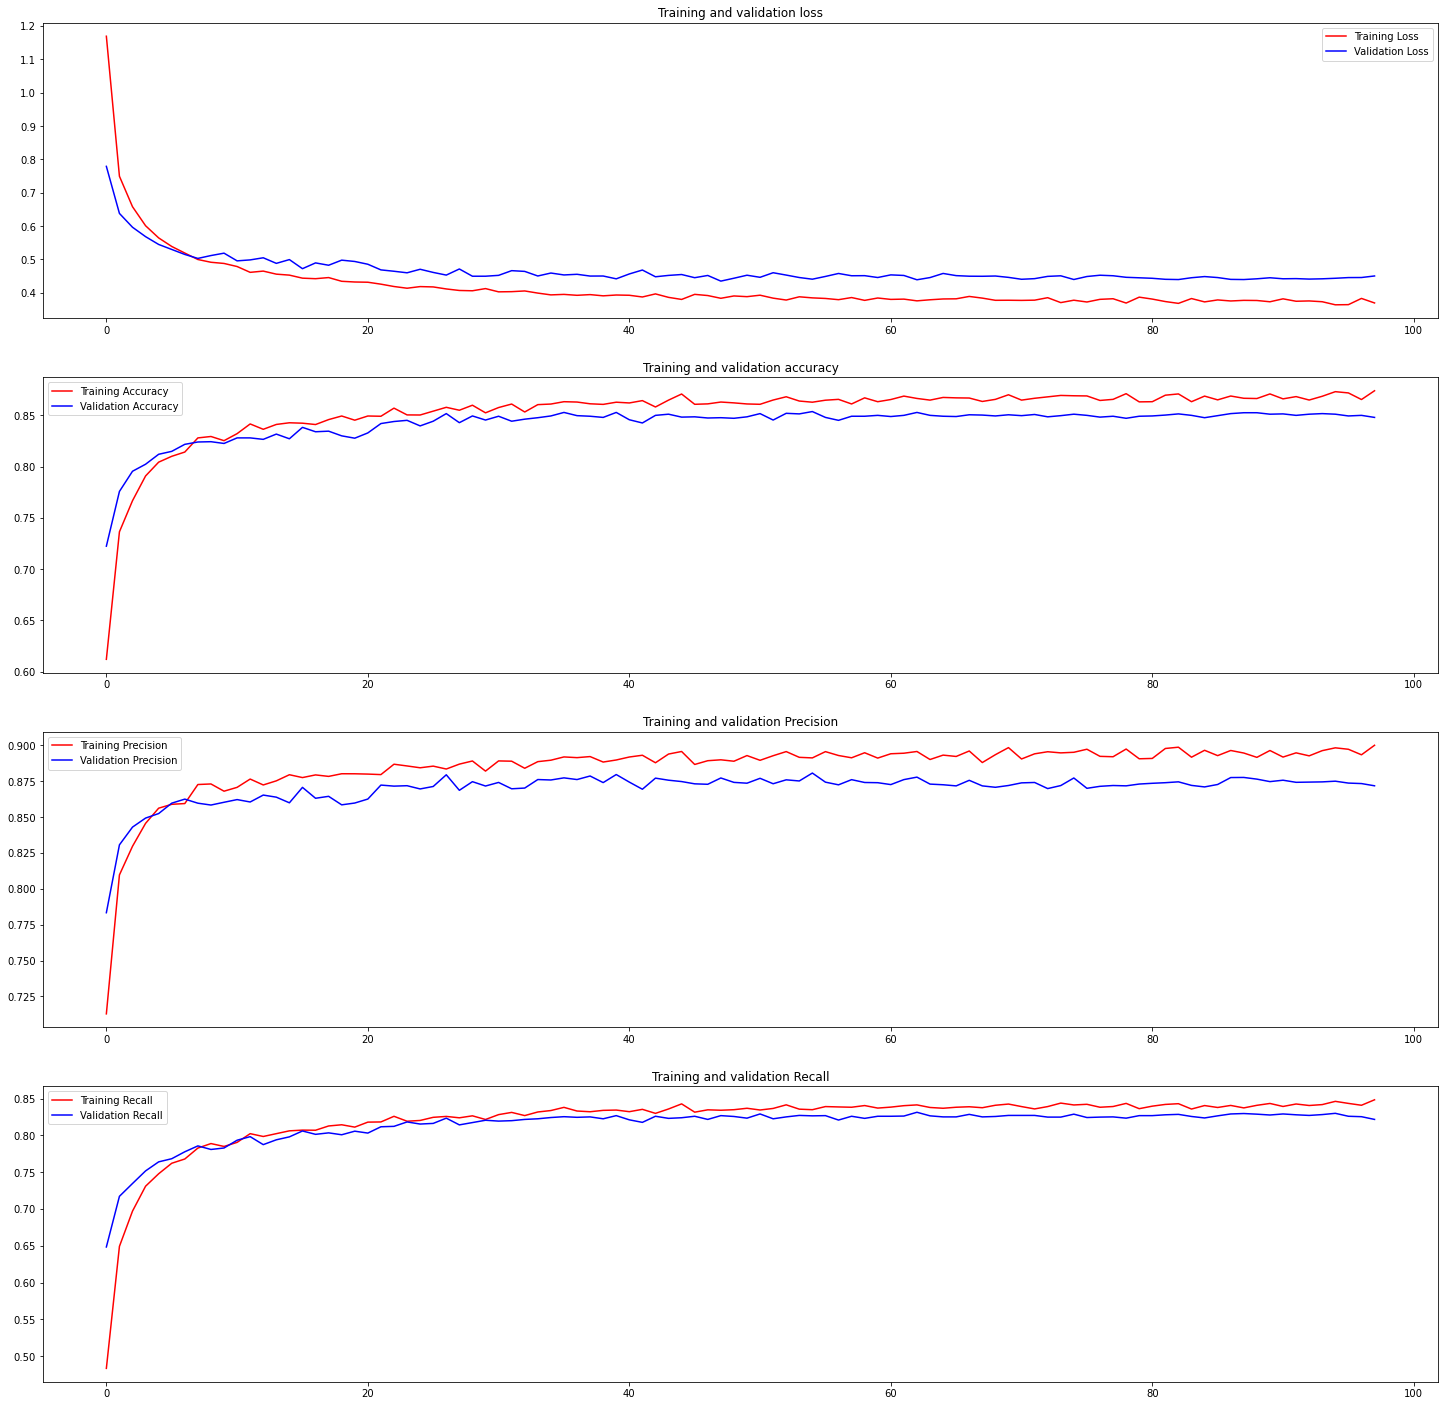

(3502,) (3502,)
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       253
           1       0.79      0.86      0.83       229
           2       0.97      0.77      0.86       199
           3       0.91      0.62      0.74       190
           4       0.64      0.93      0.76       222
           5       0.86      0.85      0.85       212
           6       0.82      0.80      0.81       203
           7       0.72      0.72      0.72       207
           8       0.90      0.91      0.90      1787

    accuracy                           0.85      3502
   macro avg       0.83      0.80      0.80      3502
weighted avg       0.86      0.85      0.85      3502



In [7]:
plotResults(history)
printClassificationReport(model, validation_ds)

In [8]:
model.save('resnet_model')

!zip -r resnet_model.zip resnet_model

2021-11-17 05:05:37.796862: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


updating: resnet_model/ (stored 0%)
updating: resnet_model/saved_model.pb (deflated 92%)
updating: resnet_model/variables/ (stored 0%)
updating: resnet_model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: resnet_model/variables/variables.index (deflated 78%)
updating: resnet_model/keras_metadata.pb (deflated 96%)
updating: resnet_model/assets/ (stored 0%)


## Fine-tuning the Model

Approach: Unfreeze the back half of the model and continue to train it using 1/50 of the learning rate (arbitrary number)

Batch Size - 64

In [3]:
model = tf.keras.models.load_model('resnet_model')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [4]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

FINETUNING_MODIFIER = 1/50

base_model = model.get_layer('resnet50')

base_model.trainable = True
adam = tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE * FINETUNING_MODIFIER)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['Precision', 'Recall', 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = EARLY_STOPPING_PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

finetuning_hist = model.fit(train_ds, validation_data = validation_ds, 
                    epochs = MAX_EPOCHS, callbacks = [early_stopping, reduce_lr], batch_size = BATCH_SIZE)

Epoch 1/1000


2021-11-17 06:29:30.713921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 06:29:36.330575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


192/192 [==============================] - 190s 935ms/step - loss: 0.3679 - precision: 0.8955 - recall: 0.8510 - accuracy: 0.8715 - val_loss: 0.3815 - val_precision: 0.8871 - val_recall: 0.8552 - val_accuracy: 0.8695
Epoch 2/1000
192/192 [==============================] - 175s 911ms/step - loss: 0.2719 - precision: 0.9217 - recall: 0.8898 - accuracy: 0.9067 - val_loss: 0.4082 - val_precision: 0.8858 - val_recall: 0.8641 - val_accuracy: 0.8746
Epoch 3/1000
192/192 [==============================] - 175s 913ms/step - loss: 0.2170 - precision: 0.9369 - recall: 0.9152 - accuracy: 0.9257 - val_loss: 0.3297 - val_precision: 0.9108 - val_recall: 0.8918 - val_accuracy: 0.8986
Epoch 4/1000
192/192 [==============================] - 175s 912ms/step - loss: 0.1912 - precision: 0.9449 - recall: 0.9250 - accuracy: 0.9345 - val_loss: 0.3161 - val_precision: 0.9101 - val_recall: 0.8932 - val_accuracy: 0.9001
Epoch 5/1000
192/192 [==============================] - 175s 912ms/step - loss: 0.1720 - prec

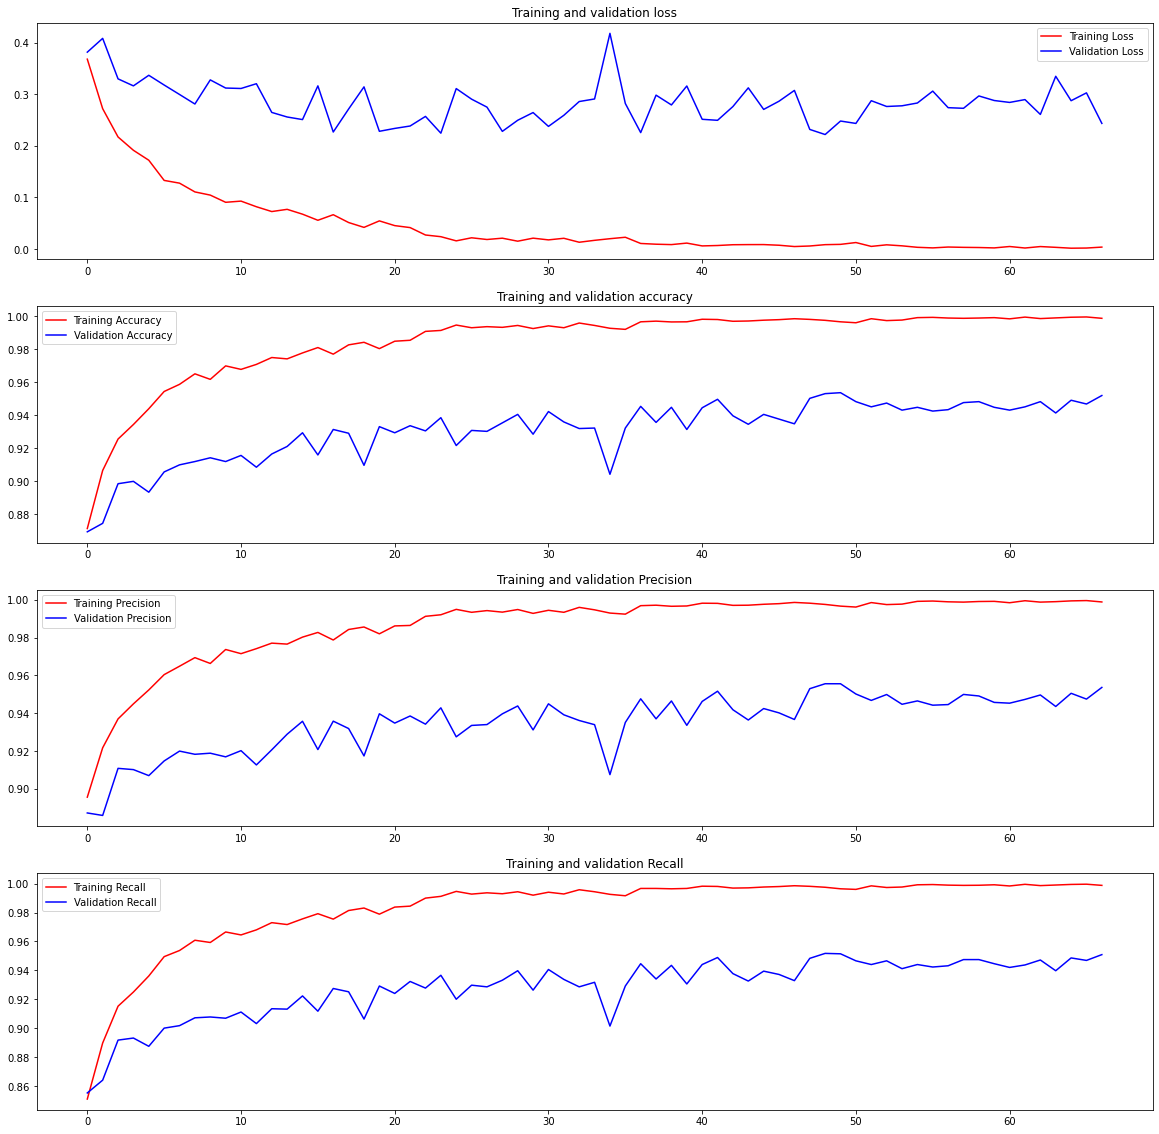

(3502,) (3502,)
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       253
           1       0.96      0.93      0.94       229
           2       0.96      0.90      0.93       199
           3       0.95      0.89      0.92       190
           4       0.77      0.98      0.86       222
           5       0.97      0.90      0.93       212
           6       0.95      0.99      0.97       203
           7       0.76      0.93      0.84       207
           8       0.97      0.95      0.96      1787

    accuracy                           0.93      3502
   macro avg       0.91      0.92      0.91      3502
weighted avg       0.94      0.93      0.93      3502



In [14]:
plotResults(finetuning_hist)
printClassificationReport(model, validation_ds)

In [7]:
model.save('resnet_finetuned_model')

!zip -r resnet_finetuned_model.zip resnet_finetuned_model

2021-11-17 09:52:55.325313: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet_finetuned_model/assets


INFO:tensorflow:Assets written to: resnet_finetuned_model/assets
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


  adding: resnet_finetuned_model/ (stored 0%)
  adding: resnet_finetuned_model/saved_model.pb (deflated 92%)
  adding: resnet_finetuned_model/variables/ (stored 0%)
  adding: resnet_finetuned_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: resnet_finetuned_model/variables/variables.index (deflated 80%)
  adding: resnet_finetuned_model/keras_metadata.pb (deflated 96%)
  adding: resnet_finetuned_model/assets/ (stored 0%)
